In [1]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

# NOTE: this is only policy evaluation, not optimization

# we'll try to obtain the same result as our other MC script
from monte_carlo_random import random_action, play_game, SMALL_ENOUGH, GAMMA, ALL_POSSIBLE_ACTIONS

LEARNING_RATE = 0.001

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


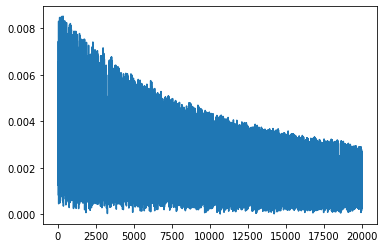

values:
---------------------------
 0.40| 0.53| 0.67| 0.00|
---------------------------
 0.33| 0.00| 0.35| 0.00|
---------------------------
 0.25| 0.14| 0.02|-0.10|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |


In [2]:
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # found by policy_iteration_random on standard_grid
  # MC method won't get exactly this, but should be close
  # values:
  # ---------------------------
  #  0.43|  0.56|  0.72|  0.00|
  # ---------------------------
  #  0.33|  0.00|  0.21|  0.00|
  # ---------------------------
  #  0.25|  0.18|  0.11| -0.17|
  # policy:
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   U  |      |   U  |      |
  # ---------------------------
  #   U  |   L  |   U  |   L  |
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
  }

  # initialize theta
  # our model is V_hat = theta.dot(x)
  # where x = [row, col, row*col, 1] - 1 for bias term
  theta = np.random.randn(4) / 2
  def s2x(s):
    return np.array([s[0] - 1, s[1] - 1.5, s[0]*s[1] - 3, 1])

  # repeat until convergence
  deltas = []
  t = 1.0
  for it in range(20000):
    if it % 100 == 0:
      t += 0.01
    alpha = LEARNING_RATE/t
    # generate an episode using pi
    biggest_change = 0
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        old_theta = theta.copy()
        x = s2x(s)
        V_hat = theta.dot(x)
        # grad(V_hat) wrt theta = x
        theta += alpha*(G - V_hat)*x
        biggest_change = max(biggest_change, np.abs(old_theta - theta).sum())
        seen_states.add(s)
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  # obtain predicted values
  V = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      V[s] = theta.dot(s2x(s))
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

#### UCB

In [3]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import matplotlib.pyplot as plt
from comparing_epsilons import run_experiment as run_experiment_eps

In [4]:
#bandit
class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x

In [5]:
#method
def ucb(mean, n, nj):
  if nj == 0:
    return float('inf')
  return mean + np.sqrt(2*np.log(n) / nj)


def run_experiment(m1, m2, m3, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    j = np.argmax([ucb(b.mean, i+1, b.N) for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # for b in bandits:
  #   print("bandit nj:", b.N)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  # for b in bandits:
  #   print(b.mean)

  return cumulative_average

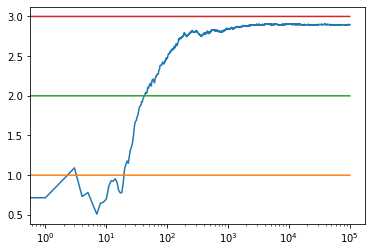

1.0029509052270584
2.0032225580891283
2.9973882789344293


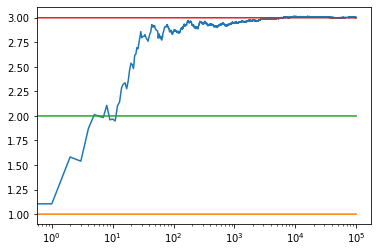

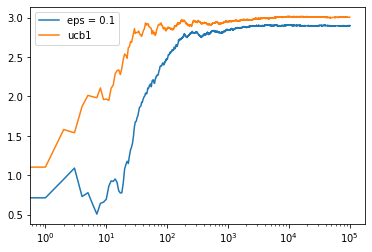

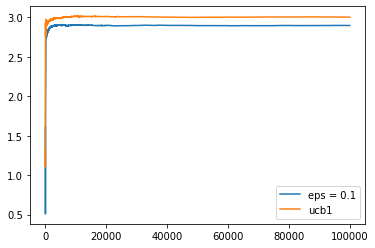

In [6]:
#main
if __name__ == '__main__':
  eps = run_experiment_eps(1.0, 2.0, 3.0, 0.1, 100000)
  ucb = run_experiment(1.0, 2.0, 3.0, 100000)

  # log scale plot
  plt.plot(eps, label='eps = 0.1')
  plt.plot(ucb, label='ucb1')
  plt.legend()
  plt.xscale('log')
  plt.show()


  # linear plot
  plt.plot(eps, label='eps = 0.1')
  plt.plot(ucb, label='ucb1')
  plt.legend()
  plt.show()

#### value Prediction

In [7]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [8]:
#main
if __name__ == '__main__':
  # this grid gives you a reward of -0.1 for every non-terminal state
  # we want to see if this will encourage finding a shorter path to the goal
  grid = negative_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # we'll randomly choose an action and update as we learn
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initial policy
  print("initial policy:")
  print_policy(policy, grid)

  # initialize V(s)
  V = {}
  states = grid.all_states()
  for s in states:
    # V[s] = 0
    if s in grid.actions:
      V[s] = np.random.random()
    else:
      # terminal state
      V[s] = 0

  # repeat until convergence
  # V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + gamma*V[s']] } }
  while True:
    biggest_change = 0
    for s in states:
      old_v = V[s]

      # V(s) only has value if it's not a terminal state
      if s in policy:
        new_v = float('-inf')
        for a in ALL_POSSIBLE_ACTIONS:
          grid.set_state(s)
          r = grid.move(a)
          v = r + GAMMA * V[grid.current_state()]
          if v > new_v:
            new_v = v
        V[s] = new_v
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if biggest_change < SMALL_ENOUGH:
      break

  # find a policy that leads to optimal value function
  for s in policy.keys():
    best_a = None
    best_value = float('-inf')
    # loop through all possible actions to find the best current action
    for a in ALL_POSSIBLE_ACTIONS:
      grid.set_state(s)
      r = grid.move(a)
      v = r + GAMMA * V[grid.current_state()]
      if v > best_value:
        best_value = v
        best_a = a
    policy[s] = best_a

  # our goal here is to verify that we get the same answer as with policy iteration
  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
initial policy:
---------------------------
  U  |  D  |  L  |     |
---------------------------
  U  |     |  D  |     |
---------------------------
  D  |  R  |  R  |  D  |
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
